<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/FontCGAN_proper_worse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from torch.autograd import grad
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset
from torch.autograd import grad
from collections import defaultdict

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [110]:
ngf = 32
nc = 1
ndf = 32

In [111]:
class Generator3(nn.Module):
    def __init__(self, latent_dim, num_classes=26):
        super(Generator3, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = 128  # Encoded condition size

        # Condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 8 * 128, self.condition_dim),
            nn.ReLU()
        )

        # Fully connected layers
        self.fc = nn.Linear(latent_dim + num_classes + self.condition_dim, 512 * 2 * 2)

        # Deconvolutional blocks
        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, z, label, condition_image):
        condition = self.condition_encoder(condition_image)
        z_combined = torch.cat((z, label, condition), dim=1)
        out = self.fc(z_combined)
        out = out.view(out.size(0), 512, 2, 2)
        img = self.deconv_blocks(out)
        return img



class Discriminator3(nn.Module):
    def __init__(self, num_classes=26):
        super(Discriminator3, self).__init__()
        self.label_embedding = nn.Linear(num_classes, 32 * 32)

        self.main = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Input: (1+1)x32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)  # Output: scalar validity
        )

    def forward(self, img, label, condition_img):
        label_embedding = self.label_embedding(label).view(-1, 1, 32, 32)
        x = torch.cat((img, condition_img), dim=1)
        validity = self.main(x)
        return validity



In [112]:
npz_file = '/content/gdrive/My Drive/character_font.npz'

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [113]:
class FontConditionalDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)
        self.images = data['images']  # Shape: (N, 32, 32)
        self.labels = data['labels']  # Shape: (N,)
        self.num_fonts = len(self.images) // 26  # Number of fonts
        self.num_letters = 26  # Number of letters (A-Z)
        self.transform = transform

        # Precompute all valid (condition_image, target_image) pairs
        self.pairs = []
        for font_idx in range(self.num_fonts):
            for letter_idx in range(self.num_letters):
                condition_idx = font_idx * self.num_letters + letter_idx
                if condition_idx >= len(self.images):
                    continue

                target_idx = font_idx * self.num_letters + (letter_idx - 1) % self.num_letters
                if target_idx >= len(self.images):
                    continue

                self.pairs.append((condition_idx, target_idx))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
      # Retrieve "A" (condition) and target images
      font_idx = idx // self.num_letters
      condition_idx = font_idx * self.num_letters  # Index of 'A'
      target_idx = idx

      condition_image = self.images[condition_idx]
      target_image = self.images[target_idx]

      # Normalize and one-hot encode
      if self.transform:
          condition_image = self.transform(condition_image)
          target_image = self.transform(target_image)

      target_label = target_idx % self.num_letters
      target_label_one_hot = torch.zeros(self.num_letters)
      target_label_one_hot[target_label] = 1

      return condition_image, target_label_one_hot, target_image



In [114]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [115]:
def number_to_alphabet(num):
    if 0 <= num <= 25:
        return chr(num + 65)  # 65 is the ASCII code for 'A'
    else:
        raise ValueError("Number must be between 0 and 25 inclusive.")


In [116]:
def displayGeneratedImage(class_index, generator, z_s, num_classes, condition_img, device='cuda'):
    """
    Generates and displays an image for a given class using the generator.

    Args:
        class_index (int): Index of the character class to generate (0 to num_classes - 1).
        generator (nn.Module): Pre-trained generator model.
        z_s (torch.Tensor): Style vector of shape (1, z_dim).
        num_classes (int): Number of character classes.
        condition_img (torch.Tensor): Conditional image of shape (1, 32, 32).
        device (str): Device for computation ('cuda' or 'cpu').
    """
    # Ensure the class index is valid
    if not (0 <= class_index < num_classes):
        raise ValueError(f"Invalid class_index: {class_index}. Must be in range [0, {num_classes - 1}].")

    # Create the one-hot vector for the class
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[0, class_index] = 1  # Set the desired class

    # Ensure the conditional image is in the correct shape
    condition_img = condition_img.unsqueeze(0).to(device)  # Add batch dimension if needed

    # Generate the image
    with torch.no_grad():
        generated_img = generator(z_s, z_c, condition_img).cpu().numpy()[0, 0]  # Extract the first batch and channel

    # Rescale the image from [-1, 1] to [0, 255]
    generated_img = np.uint8(np.interp(generated_img, (-1, 1), (0, 255)))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_img, cmap='gray')
    plt.axis("off")
    plt.title(f"Generated Image for Class {number_to_alphabet(class_index)}")
    plt.show()


In [117]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)

In [118]:
# Hyperparameters
z_dim = 512
num_classes = 26  # For uppercase alphabets
img_size = 32  # Assuming 32x32 images
batch_size = 1024
lr = 0.0005
lambda_gp = 10  # Gradient penalty weight
n_critic = 5  # Number of discriminator updates per generator update
epochs = 1000
from torch.utils.data import random_split

# Load the full dataset
full_data = FontConditionalDataset(npz_file, transform)

# Split sizes
total_size = len(full_data)
train_size = int(0.2 * total_size)  # 20% for training
test_size = int(0.1 * total_size)   # 10% for testing
validation_size = int(0.1 * total_size)  # 10% for validation

# Ensure the splits add up to the total size
remaining_size = total_size - (train_size + test_size + validation_size)

# Distribute the remaining size (if any) to one of the splits to ensure correct distribution
if remaining_size > 0:
    validation_size += remaining_size  # Add leftovers to validation split

# Split the dataset
train_data, test_data, val_data = random_split(full_data, [train_size, test_size, validation_size])

print(f"Total data size: {total_size}")
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")
print(f"Validation data size: {len(val_data)}")


Total data size: 389740
Training data size: 77948
Testing data size: 38974
Validation data size: 272818


In [119]:
npz_file = '/content/gdrive/My Drive/character_font.npz'
# Load the dataset
#dataset = FontConditionalDataset(npz_file=npz_file, transform=transform)

# Create DataLoader
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and optimizers


In [120]:
def display_images_from_dataloader(dataloader, generator=None, z_dim=None, num_classes=26, device="cuda", num_samples=5):
    """
    Displays condition images, target images, and optionally generated images from the dataloader.

    Args:
        dataloader (DataLoader): The dataloader to pull samples from.
        generator (nn.Module, optional): The generator model to produce generated images. If None, only real images are shown.
        z_dim (int, optional): The latent dimension for the generator's input.
        num_classes (int, optional): The number of classes (default is 26 for A-Z).
        device (str, optional): Device to run the generator (e.g., "cuda" or "cpu").
        num_samples (int, optional): Number of samples to display.
    """
    # Get a batch of data
    data_iter = iter(dataloader)
    condition_imgs, target_labels, target_imgs = next(data_iter)

    # Move data to device
    condition_imgs = condition_imgs[:num_samples].unsqueeze(1).to(device)  # Shape: (num_samples, 1, 32, 32)
    target_imgs = target_imgs[:num_samples].unsqueeze(1).to(device)        # Shape: (num_samples, 1, 32, 32)
    target_labels = target_labels[:num_samples].to(device)                # Shape: (num_samples, num_classes)

    # Initialize latent noise for the generator
    if generator is not None and z_dim is not None:
        z_s = torch.randn(num_samples, z_dim).to(device)  # Latent noise
        generated_imgs = generator(z_s, target_labels, condition_imgs).detach().cpu()  # Generate images
    else:
        generated_imgs = None

    # Create a figure to display images
    fig, axes = plt.subplots(num_samples, 3 if generator else 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Plot condition image
        axes[i, 0].imshow(condition_imgs[i].squeeze().cpu().numpy(), cmap="gray")
        axes[i, 0].set_title("Condition Image")
        axes[i, 0].axis("off")

        # Plot target image
        axes[i, 1].imshow(target_imgs[i].squeeze().cpu().numpy(), cmap="gray")
        axes[i, 1].set_title("Target Image")
        axes[i, 1].axis("off")

        # Plot generated image (if generator is provided)
        if generator is not None:
            axes[i, 2].imshow(generated_imgs[i].squeeze().numpy(), cmap="gray")
            axes[i, 2].set_title("Generated Image")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

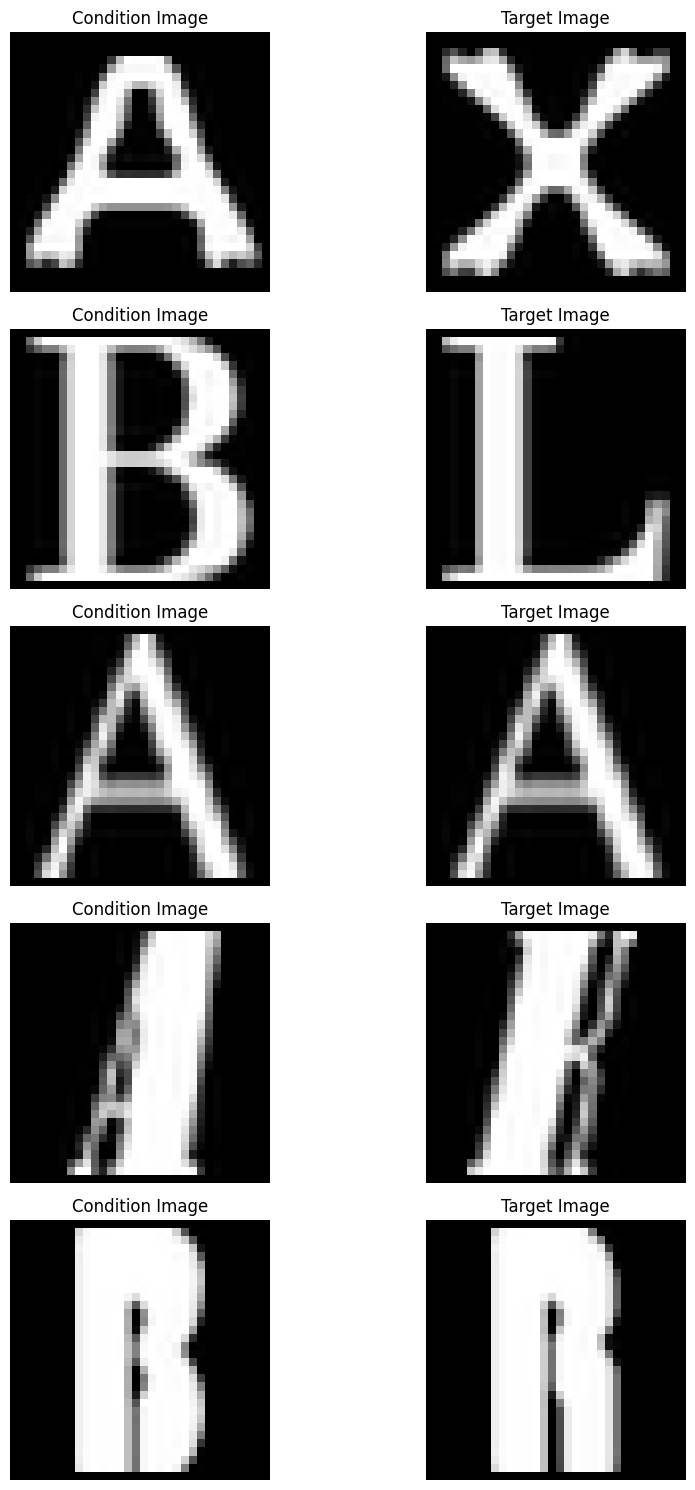

In [121]:
# Display images from the dataloader
display_images_from_dataloader(
    dataloader=dataloader,  # Example: Dataloader for the first letter
    generator=None,  # Pass the generator model to visualize generated images
    # z_dim=z_dim,  # Latent dimension
    num_classes=num_classes,
    device=device,
    num_samples=5  # Number of samples to display
)


In [122]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, condition_imgs, labels):
    """
    Compute the gradient penalty for WGAN-GP.

    Args:
        discriminator (nn.Module): The discriminator model.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        condition_imgs (Tensor): Conditional images.
        labels (Tensor): One-hot encoded labels for the target letters.

    Returns:
        Tensor: Gradient penalty value.
    """
    device = real_samples.device

    # Random weight for interpolation
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)  # Shape: (batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_samples)

    # Interpolated samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Ensure condition_imgs and labels are not None
    assert condition_imgs is not None, "condition_imgs cannot be None for gradient penalty."
    assert labels is not None, "labels cannot be None for gradient penalty."

    # Compute discriminator output for interpolated samples
    d_interpolates = discriminator(interpolates, labels, condition_imgs)

    # Compute gradients
    grad_outputs = torch.ones(d_interpolates.size(), device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)  # Flatten gradients
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty



In [123]:
def test_generator(generator, test_dataloader, z_dim, num_classes, device):
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        for i, (condition_imgs, target_labels, target_imgs) in enumerate(test_dataloader):
            # Move data to the appropriate device
            condition_imgs = condition_imgs.to(device)  # Add channel dimension
            target_labels = target_labels.to(device)
            batch_size = condition_imgs.size(0)

            # Generate latent noise
            z_s = torch.randn(batch_size, z_dim, device=device)

            # Display or evaluate generated images
            #for j in range(batch_size):
                # Extract data for the current sample
            condition_img = condition_imgs[0]
            z_s_single = z_s[0:0+1]  # Extract single latent vector
            target_label = torch.argmax(target_labels[0]).item()  # Extract scalar label

                # Display generated image using the updated function
            displayGeneratedImage(
                    class_index=target_label,
                    generator=generator,
                    z_s=z_s_single,
                    num_classes=num_classes,
                    condition_img=condition_img,
                    device=device
                )

    generator.train()  # Return generator to training mode


In [128]:
z_dim = 100
num_classes = 26
img_size = 32
batch_size = 64
lr = 0.0001
lambda_gp = 10
n_critic = 5
epochs = 1000

# Initialize models
generator = Generator3(latent_dim=z_dim).cuda()
discriminator = Discriminator3(num_classes=num_classes).cuda()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Dataset and DataLoader
#dataset = FontConditionalDataset("path_to_data.npz", transform=transform)
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for i, (condition_imgs, target_labels, target_imgs) in enumerate(dataloader):
        condition_imgs = condition_imgs.cuda()
        target_imgs = target_imgs.cuda()
        target_labels = target_labels.cuda()
        batch_size = condition_imgs.size(0)

        # ---------------------
        # Train Discriminator
        # ---------------------
        z = torch.randn(batch_size, z_dim).cuda()
        fake_imgs = generator(z, target_labels, condition_imgs)

        real_validity = discriminator(target_imgs, target_labels, condition_imgs)
        fake_validity = discriminator(fake_imgs.detach(), target_labels, condition_imgs)
        gradient_penalty = compute_gradient_penalty(
            discriminator, target_imgs, fake_imgs.detach(), condition_imgs, target_labels
        )

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        if i % n_critic == 0:
            # Recompute fake images
            fake_imgs = generator(z, target_labels, condition_imgs)
            fake_validity = discriminator(fake_imgs, target_labels, condition_imgs)
            g_loss = -torch.mean(fake_validity)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()
        if (epoch + 1) % 100 == 0:  # Test every 100 epochs
          z_s = torch.randn(1, z_dim).cuda()
          test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

          for i, (condition_imgs, target_labels, target_imgs) in enumerate(test_dataloader):
              condition_img = condition_imgs.squeeze(0)  # Shape: 1x32x32

              # Display the conditional image
              plt.figure(figsize=(5, 5))
              plt.imshow(condition_img.cpu().numpy().squeeze(), cmap='gray')  # Ensure correct shape for display
              plt.axis("off")
              plt.title("Conditional Input Image")
              plt.show()

              # Generate and display images for all classes
              for class_index in range(num_classes):
                  # Prepare one-hot target label
                  target_label = torch.zeros(1, num_classes).to(device)
                  target_label[0, class_index] = 1

                  # Generate the image for the current class
                  displayGeneratedImage(
                      class_index=class_index,
                      generator=generator,
                      z_s=z_s,
                      num_classes=num_classes,
                      condition_img=condition_img,
                      device=device
                  )
              break


    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
    print("Generator Gradients:")
    for name, param in generator.named_parameters():
            if param.grad is not None:
                print(f"{name}: {param.grad.norm().item()}")
    print("Critic Gradients:")
    for name, param in discriminator.named_parameters():
                if param.grad is not None:
                    print(f"{name}: {param.grad.norm().item()}")
    print("Grad Penalty:", gradient_penalty)


KeyboardInterrupt: 

In [126]:
import os
from PIL import Image

In [127]:
# Define the base path and subdirectories for saving images in Google Drive
base_folder = '/content/gdrive/My Drive/GeneratedImages'
condition_folder = os.path.join(base_folder, 'ConditionImages')
generated_folder = os.path.join(base_folder, 'GeneratedImages')

# Create all necessary directories
os.makedirs(base_folder, exist_ok=True)  # Create the main folder
os.makedirs(condition_folder, exist_ok=True)  # Create folder for condition images
os.makedirs(generated_folder, exist_ok=True)  # Create folder for generated images

def save_image(image_tensor, save_path):
    """
    Save a single image tensor as a PNG file.
    """
    image = transforms.ToPILImage()(image_tensor.squeeze(0).cpu())
    image.save(save_path)

# Generate and save images
z_s = torch.randn(1, z_dim).cuda()
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

for i, (condition_imgs, target_labels, target_imgs) in enumerate(test_dataloader):
    # Extract a single condition image (remove batch dimension)
    condition_img = condition_imgs.squeeze(0)  # Shape: 1x32x32
    condition_save_path = os.path.join(condition_folder, f'condition_{i}.png')
    save_image(condition_img, condition_save_path)  # Save condition image

    # Generate and save images for all classes
    for class_index in range(num_classes):
        # Prepare one-hot target label
        target_label = torch.zeros(1, num_classes).to(device)
        target_label[0, class_index] = 1

        # Generate the image for the current class
        generated_img = generator(z_s, target_label, condition_img.unsqueeze(0).to(device)).squeeze(0)

        # Define the save path
        generated_save_path = os.path.join(generated_folder, f'generated_{i}_class_{class_index}.png')
        save_image(generated_img, generated_save_path)

print("Images have been saved to your Google Drive.")

KeyboardInterrupt: 